In [ ]:
import pandas as pd       #importing the required libraries
import spacy
import os
import glob
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import itertools
import networkx as nx
import collections
from nltk import bigrams
import dateutil
import nltk 

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Read all data files into one dataframe
df = pd.read_csv('/content/drive/MyDrive/FDA3/2017.csv')
cols = df.columns
data = pd.DataFrame(columns=cols)
for i in os.listdir('/content/drive/MyDrive/FDA3/'):
  data1 = pd.read_csv('/content/drive/MyDrive/FDA3/' + i)
  data = pd.concat([data,data1])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,reply_to,retweet_date,translate,trans_src,trans_dest,time,mentions,replies_count,retweets_count,likes_count
0,NaN,1500030191837589510,1499972826828259328,2022-03-05 12:47:21 Arabian Standard Time,2022-03-05,400,NaN,"@SpacePadreIsle In a way, this is free QA haha",en,[],...,"[{'screen_name': 'SpacePadreIsle', 'name': 'SP...",NaN,NaN,NaN,NaN,12:47:21,[],250.0,205.0,4490.0
1,NaN,1500028396436340736,1499802655421448192,2022-03-05 12:40:13 Arabian Standard Time,2022-03-05,400,NaN,@teslaownersSV A beautiful home for life,en,[],...,"[{'screen_name': 'teslaownersSV', 'name': 'Tes...",NaN,NaN,NaN,NaN,12:40:13,[],1521.0,736.0,15121.0
2,NaN,1500026380704178178,1499972826828259328,2022-03-05 12:32:12 Arabian Standard Time,2022-03-05,400,NaN,@SpacePadreIsle Some Starlink terminals near c...,en,[],...,"[{'screen_name': 'SpacePadreIsle', 'name': 'SP...",NaN,NaN,NaN,NaN,12:32:12,[],279.0,1022.0,8774.0
3,NaN,1500010328758923264,1499976967105433600,2022-03-05 11:28:25 Arabian Standard Time,2022-03-05,400,NaN,@RationalEtienne @RogerYar Exactly,en,[],...,"[{'screen_name': 'RationalEtienne', 'name': 'P...",NaN,NaN,NaN,NaN,11:28:25,[],126.0,96.0,2773.0
4,NaN,1499982913949081600,1499976967105433600,2022-03-05 09:39:29 Arabian Standard Time,2022-03-05,400,NaN,@RogerYar All news sources are partially propa...,en,[],...,"[{'screen_name': 'RogerYar', 'name': 'Дід Пана...",NaN,NaN,NaN,NaN,09:39:29,[],1415.0,6191.0,43964.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,NaN,1345384139969552389,1345382294966571008,2021-01-02 18:59:09 Arabian Standard Time,2021-01-02,400,NaN,@flcnhvy Tesla is responsible for 2/3 of all t...,en,[],...,"[{'screen_name': 'flcnhvy', 'name': 'Viv ✶', '...",NaN,NaN,NaN,NaN,18:59:09,[],630.0,659.0,12858.0
3111,NaN,1345382294966571008,1345382294966571008,2021-01-02 18:51:49 Arabian Standard Time,2021-01-02,400,NaN,So proud of the Tesla team for achieving this ...,en,[],...,[],NaN,NaN,NaN,NaN,18:51:49,[],4026.0,6002.0,106990.0
3112,NaN,1345344958710992897,1345334831719337984,2021-01-02 16:23:28 Arabian Standard Time,2021-01-02,400,NaN,"@newscientist Um, we have giant fusion reactor...",en,[],...,"[{'screen_name': 'newscientist', 'name': 'New ...",NaN,NaN,NaN,NaN,16:23:28,[],1860.0,2271.0,51416.0
3113,NaN,1345208391958888448,1344675033231237120,2021-01-02 07:20:48 Arabian Standard Time,2021-01-02,400,NaN,@comma_ai Tesla Full Self-Driving will work at...,en,[],...,"[{'screen_name': 'comma_ai', 'name': 'comma', ...",NaN,NaN,NaN,NaN,07:20:48,[],663.0,894.0,20211.0


In [ ]:
data1 = data[['date','tweet']]                                                 #printing the data containing the tweets

In [ ]:
data1

,date,tweet
0,2022-03-05,"@SpacePadreIsle In a way, this is free QA haha"
1,2022-03-05,@teslaownersSV A beautiful home for life
2,2022-03-05,@SpacePadreIsle Some Starlink terminals near c...
3,2022-03-05,@RationalEtienne @RogerYar Exactly
4,2022-03-05,@RogerYar All news sources are partially propa...
...,...,...
3110,2021-01-02,@flcnhvy Tesla is responsible for 2/3 of all t...
3111,2021-01-02,So proud of the Tesla team for achieving this ...
3112,2021-01-02,"@newscientist Um, we have giant fusion reactor..."
3113,2021-01-02,@comma_ai Tesla Full Self-Driving will work at...


In [ ]:
def cleaning(tweet):                                            #cleaning of the data
    tweet = re.sub(r'http\S+', ' ', tweet)                   #removing of web links
    tweet = re.sub(r"www.\S+", " ", tweet)
    tweet = re.sub("[@&#][A-Za-z0-9_]+"," ", tweet.lower())  #removing hashtags and other unnessary symbols
    tweet = re.sub('[()!?]', ' ', tweet)                     #removing !?()
    tweet = re.sub('\[.*?\]',' ', tweet)                     #removing . * and other punctuation marks that are not needed
    tweet = re.sub("[^a-z0-9]"," ", tweet)                   #removing values that are not alphanumeric
    tweet = re.sub(r'[0-9]+', ' ', tweet)                    #removing numbers
    word_tokens = word_tokenize(tweet)
    fil = [w for w in word_tokens if not w in stop_words]    #checking if w is in word tokens or w is in stop words
    
    if len(fil)==0:                                          #checking if the length is equal to zero
        return float('NaN')
    else:
        
        return ' '.join(fil)
    

In [ ]:
import nltk                                                  #importing the library nltk
nltk.download('punkt')                                       #downloading punkt        
data1['tweet'] = data1['tweet'].apply(cleaning)                #applying the cleaning to the tweet data     
data1['date'] = pd.to_datetime(data1['date'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TypeError: ignored

In [ ]:
data1

,date,tweet
0,2022-03-05,way free qa haha
1,2022-03-05,beautiful home life
2,2022-03-05,starlink terminals near conflict areas jammed ...
3,2022-03-05,exactly
4,2022-03-05,news sources partially propaganda others
...,...,...
3110,2021-01-02,tesla responsible personal professional pain l...
3111,2021-01-02,proud tesla team achieving major milestone sta...
3112,2021-01-02,um giant fusion reactor sky works maintenance
3113,2021-01-02,tesla full self driving work safety level well...


In [ ]:
def year(date):                                            #process to get the year 
    return date.year                                       #returning the year
data1['year'] = data1['date'].apply(year)

<ipython-input-14-c9615119d99b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['year'] = data1['date'].apply(year)


In [ ]:
data1 = data1[data1['tweet'].notna()]                              #getting the rows that are null

In [ ]:
def frequency(document):
    return nltk.FreqDist(document)

In [ ]:
f_2017= frequency(word_tokenize(' '.join(data1[data1['year']==2017]['tweet'])))      #getting word frequency for 2017
f_2018= frequency(word_tokenize(' '.join(data1[data1['year']==2018]['tweet'])))      #getting word frequeny  for  2018
f_2019= frequency(word_tokenize(' '.join(data1[data1['year']==2019]['tweet'])))      #getting word frequency for 2019
f_2020= frequency(word_tokenize(' '.join(data1[data1['year']==2020]['tweet'])))      #getting word frequency for 2020
f_2021= frequency(word_tokenize(' '.join(data1[data1['year']==2021]['tweet'])))      #getting word frequency for 2021
f_2022= frequency(word_tokenize(' '.join(data1[data1['year']==2022]['tweet'])))      #getting word frequency for 2022

In [ ]:
f_2017    #printing frequency for 2017

FreqDist({'tesla': 222, 'model': 177, 'yes': 162, 'good': 159, 'like': 147, 'one': 138, 'first': 129, 'next': 129, 'yeah': 117, 'right': 108, ...})

In [ ]:
f_2018   #printing frequency for 2018

FreqDist({'tesla': 877, 'car': 363, 'yes': 324, 'good': 308, 'model': 294, 'like': 285, 'would': 231, 'people': 222, 'even': 195, 'next': 192, ...})

In [ ]:
f_2019   #printing frequency for 2019

FreqDist({'tesla': 504, 'yes': 307, 'would': 198, 'great': 193, 'starship': 189, 'like': 170, 'good': 169, 'high': 148, 'much': 144, 'time': 141, ...})

In [ ]:
f_2020   #printing frequency for 2020

FreqDist({'tesla': 191, 'yes': 160, 'great': 128, 'much': 120, 'good': 112, 'would': 94, 'high': 91, 'sure': 88, 'haha': 83, 'yeah': 83, ...})

In [ ]:
f_2021   #printing frequency for 2021

FreqDist({'tesla': 213, 'great': 102, 'good': 98, 'much': 93, 'haha': 89, 'like': 89, 'would': 89, 'time': 86, 'beta': 77, 'high': 74, ...})

In [ ]:
f_2022   #printing frequency for 2022

FreqDist({'tesla': 62, 'people': 34, 'would': 32, 'yes': 32, 'one': 30, 'starlink': 28, 'good': 28, 'car': 26, 'great': 22, 'high': 22, ...})

**Year 2017**

In [ ]:
kp_2017 = pd.DataFrame(f_2017.items(),columns =['word','Frequency']).sort_values(['Frequency'],ascending =False)   #calculation of the top 10 words

**Top 10 words of 2017**

In [ ]:
kp_2017.head(10)     #printing the top 10 words

,word,Frequency
104,tesla,222
56,model,177
156,yes,162
64,good,159
37,like,147
62,one,138
16,first,129
52,next,129
8,yeah,117
113,would,108


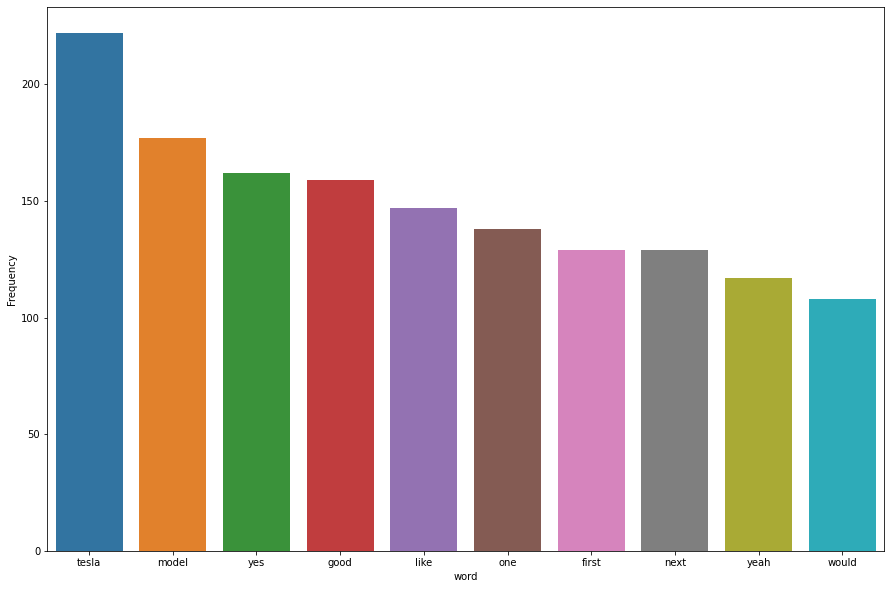

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.barplot(x='word',y='Frequency',data=kp_2017.head(10));

In [ ]:
import plotly.express as px    #importing to plot for histogram

In [ ]:
px.histogram(kp_2017, x ='Frequency', nbins =30)    #plotting of histogram for 2017 tweets by giving the bin size as 30

**Zipf's Law for 2017**

In [ ]:
kp_2017['rank'] = range(1,len(kp_2017)+1)        #addition of a rank column to the dataframe

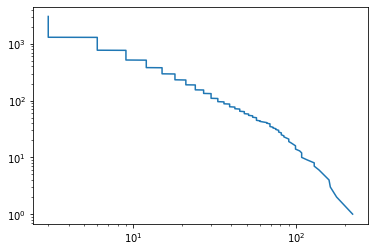

In [ ]:
plt.loglog(kp_2017['Frequency'], kp_2017['rank'] )   #zipf's law plot for the year 2017

**Bigram for 2017**

In [ ]:
def token(string):
    return word_tokenize(string)      #making the tweets into tokens

In [ ]:
data1['Tokens'] = data1['tweet'].apply(token)      #applying the token

<ipython-input-32-b07504225424>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
get_bigram2017 = [list(bigrams(tweet)) for tweet in data1[data1['year']==2017]['Tokens']]   #getting the bigram for 2017

In [ ]:

flat2017 = list(itertools.chain(*get_bigram2017))    #obtaining a flat list
counter2017 = collections.Counter(flat2017)          #making a counter

In [ ]:

bigram_dataframe2017 = pd.DataFrame(counter2017.most_common(20),columns=['bigram', 'count'])   #creating a dataframe

In [ ]:
bigram_dataframe2017                 #printing the dataframe

,bigram,count
0,"(coming, soon)",45
1,"(falcon, heavy)",45
2,"(boring, company)",39
3,"(next, year)",30
4,"(good, point)",27
5,"(model, x)",27
6,"(next, week)",24
7,"(next, month)",21
8,"(boring, machine)",18
9,"(tesla, semi)",18


In [ ]:

dictonary = bigram_dataframe2017.set_index('bigram').T.to_dict('records') #making a dictionary
G = nx.Graph()


for k, v in dictonary[0].items():       # looping it to make connection to the nodes
    G.add_edge(k[0], k[1])


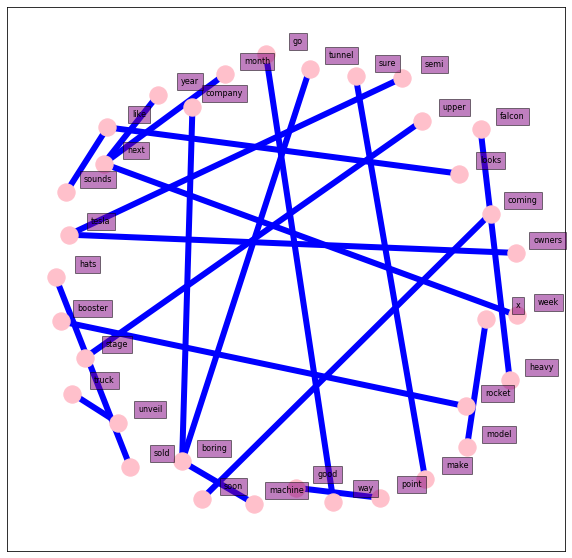

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

pos = nx.spring_layout(G, k=5)
nx.draw_networkx(G, pos,                        #plotting the networks
                 font_size=10,                   #specifying font size as 10
                 width=6,                        #specifying width as 6
                 edge_color='blue',              #specifying the edge colour as blue
                 node_color='pink',              #specifying the node colour as pink
                 with_labels = False,
                 ax=ax)


for key, value in pos.items():                 #for loop for looping the positions
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='purple', alpha=0.50), #specifying the face colour as purple
            horizontalalignment='center', fontsize=8)  #Specifying alignment as center
    
plt.show()


**Year 2018**

In [ ]:

kp_2018 = pd.DataFrame(f_2018.items(),columns =['word','Frequency']).sort_values(['Frequency'],ascending =False)   #getting the top 10 words of 2018

**Top 10 words of 2018**

In [ ]:
kp_2018.head(10)                                                                                                    #printing the top 10 words of 2018

,word,Frequency
1,tesla,877
112,car,363
28,yes,324
187,good,308
134,model,294
102,like,285
285,would,231
70,people,222
206,even,195
64,next,192


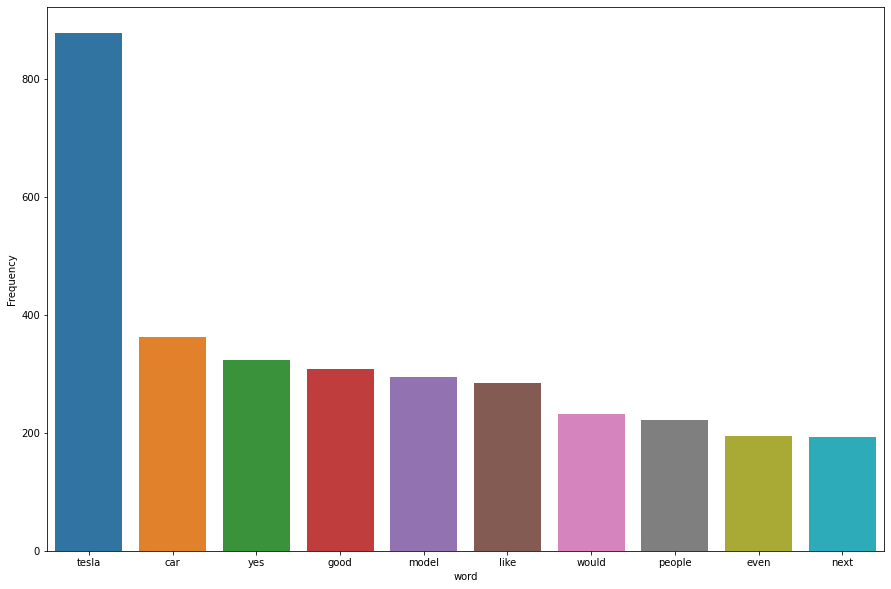

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.barplot(x='word',y='Frequency',data=kp_2018.head(10));

In [ ]:
import plotly.express as px    #importing to plot for histogram

In [ ]:
px.histogram(kp_2018, x ='Frequency', nbins =30)     #plotting histogram for 2018 tweets and taking bin size as 30

**Zipf's Law for 2018**

In [ ]:
kp_2018['rank'] = range(1,len(kp_2018)+1)    #addition of a rank column to the dataframe

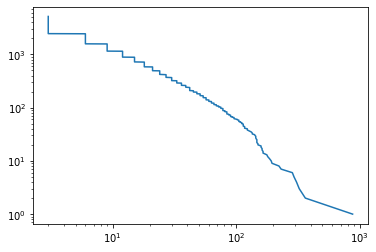

In [ ]:
plt.loglog(kp_2018['Frequency'], kp_2018['rank'] )   #zipf's law plot for the year 2018

**Bigram for 2018**

In [ ]:
get_bigram2018 = [list(bigrams(tweet)) for tweet in data1[data1['year']==2018]['Tokens']]    #biogram for 2018

In [ ]:
flat2018 = list(itertools.chain(*get_bigram2018))    #obtaining a flat list
counter2018 = collections.Counter(flat2018)          #making a counter

In [ ]:
bigram_dataframe = pd.DataFrame(counter2018.most_common(20),columns=['bigram', 'count'])   #creating a dataframe

In [ ]:
bigram_dataframe      #printing the dataframe

,bigram,count
0,"(next, year)",75
1,"(coming, soon)",66
2,"(boring, company)",48
3,"(falcon, heavy)",42
4,"(tesla, team)",35
5,"(good, idea)",33
6,"(dual, motor)",33
7,"(test, drive)",30
8,"(end, next)",30
9,"(model, performance)",30


In [ ]:
dictonary = bigram_dataframe.set_index('bigram').T.to_dict('records') #making a dictionary
G = nx.Graph()


for k, v in dictonary[0].items():       #making connection to the nodes by looping it
    G.add_edge(k[0], k[1])

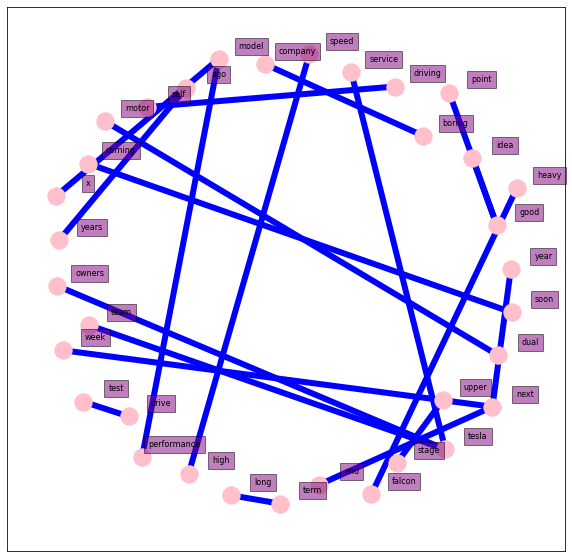

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

pos = nx.spring_layout(G, k=5)
nx.draw_networkx(G, pos,                        #plotting the networks
                 font_size=10,                   #specifying font size as 10
                 width=6,                        #specifying width as 6
                 edge_color='blue',              #specifying the edge colour as blue
                 node_color='pink',              #specifying the node colour as pink
                 with_labels = False,
                 ax=ax)


for key, value in pos.items():                 #for loop for looping the positions
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='purple', alpha=0.50), #specifying the face colour as purple
            horizontalalignment='center', fontsize=8)  #Specifying alignment as center
    
plt.show()

**Year 2019**

In [ ]:
kp_2019 = pd.DataFrame(f_2019.items(),columns =['word','Frequency']).sort_values(['Frequency'],ascending =False)    #calculation of the top 10 words of 2019

**Top 10 words of 2019**

In [ ]:
kp_2019.head(10)                         #Printing of the top 10 words of 2019

,word,Frequency
195,tesla,504
106,yes,307
55,would,198
191,great,193
162,starship,189
487,like,170
42,good,169
360,high,148
51,much,144
206,time,141


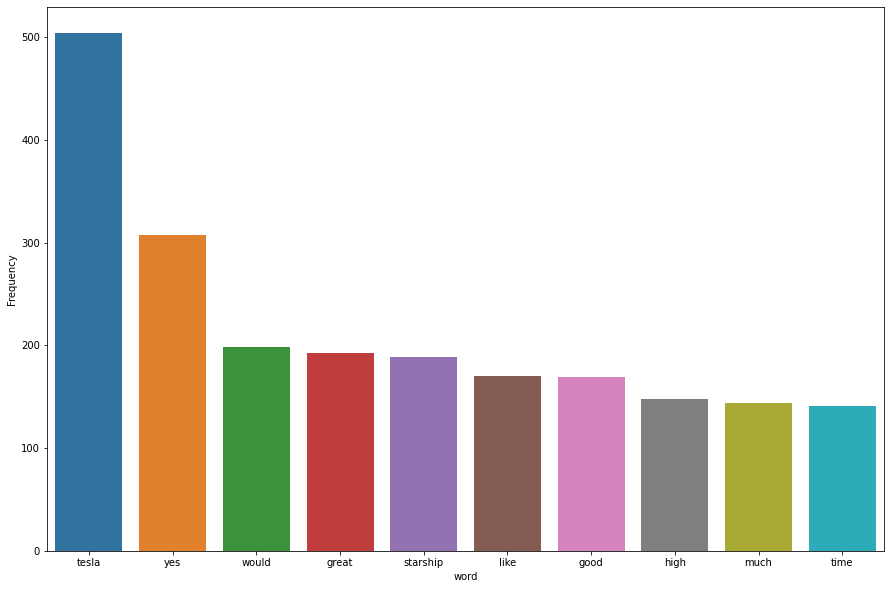

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.barplot(x='word',y='Frequency',data=kp_2019.head(10));

In [ ]:
import plotly.express as px    #importing to plot for histogram

In [ ]:

px.histogram(kp_2019, x ='Frequency', nbins =30)  #plotting histogram for 2019 tweets and taking bin size as 30

**Zipf's Law for 2019**

In [ ]:
kp_2019['rank'] = range(1,len(kp_2019)+1)      #addition of a rank column to the dataframe

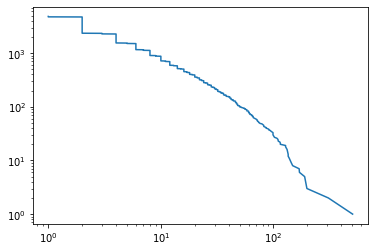

In [ ]:

plt.loglog(kp_2019['Frequency'], kp_2019['rank'] )   #zipf's law plot for the year 2019

**Bigram for 2019**

In [ ]:
get_bigram2019 = [list(bigrams(tweet)) for tweet in data1[data1['year']==2019]['Tokens']] #getting the bigram data for the year 2019

In [ ]:

flat2019 = list(itertools.chain(*get_bigram2019))    #getting the flattened list


counter2019 = collections.Counter(flat2019)          #making a counter

In [ ]:
flat2019

[('pretty', 'awful'),
 ('awful', 'lie'),
 ('lie', 'left'),
 ('left', 'south'),
 ('south', 'africa'),
 ('africa', 'backpack'),
 ('backpack', 'suitcase'),
 ('suitcase', 'books'),
 ('books', 'worked'),
 ('worked', 'mom'),
 ('mom', 'cousin'),
 ('cousin', 'farm'),
 ('farm', 'saskatchewan'),
 ('saskatchewan', 'lumber'),
 ('lumber', 'mill'),
 ('mill', 'vancouver'),
 ('vancouver', 'went'),
 ('went', 'queens'),
 ('queens', 'univ'),
 ('univ', 'scholarship'),
 ('scholarship', 'debt'),
 ('debt', 'upenn'),
 ('upenn', 'wharton'),
 ('wharton', 'stanford'),
 ('person', 'blocked'),
 ('blocked', 'read'),
 ('read', 'tweet'),
 ('tweet', 'whats'),
 ('whats', 'deal'),
 ('started', 'zip'),
 ('zip', 'k'),
 ('k', 'plus'),
 ('plus', 'overclocked'),
 ('overclocked', 'home'),
 ('home', 'built'),
 ('built', 'pc'),
 ('pc', 'k'),
 ('k', 'bro'),
 ('bro', 'k'),
 ('k', 'greg'),
 ('greg', 'kouri'),
 ('kouri', 'good'),
 ('good', 'guy'),
 ('guy', 'greatly'),
 ('greatly', 'missed'),
 ('missed', 'dad'),
 ('dad', 'provided')

In [ ]:
# Creating a bigram dataframe
bigram2019 = pd.DataFrame(counter2019.most_common(20),
                             columns=['bigram', 'count'])

In [ ]:
bigram2019                             #printing the dataframe

,bigram,count
0,"(self, driving)",44
1,"(coming, soon)",40
2,"(full, self)",40
3,"(next, week)",28
4,"(next, year)",28
5,"(super, heavy)",28
6,"(early, access)",26
7,"(smart, summon)",22
8,"(tesla, solar)",22
9,"(good, point)",18


In [ ]:

dictonary = bigram2019.set_index('bigram').T.to_dict('records')   #initialising a dictionary

In [ ]:

G = nx.Graph()


for k, v in dictonary[0].items():    #Looping using a for loop to make connections
    G.add_edge(k[0], k[1])


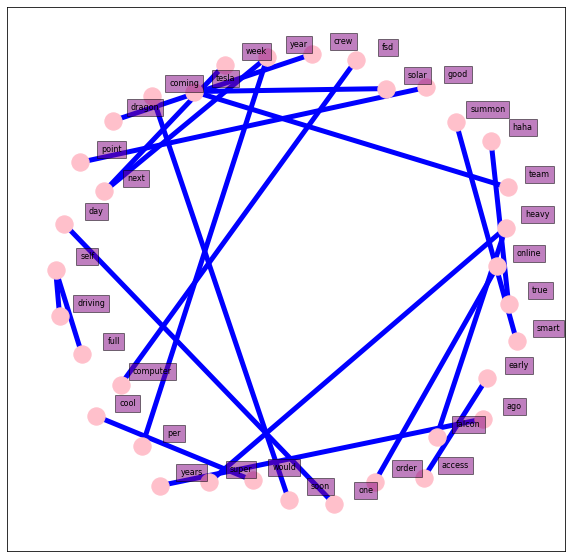

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

pos = nx.spring_layout(G, k=5)

nx.draw_networkx(G, pos,font_size=10,width=5, edge_color='blue', node_color='pink', with_labels = False, ax=ax)  #plotting the network by specifying the colors and conts


for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='purple', alpha=0.50),  #specifying the facecolor as purple
            horizontalalignment='center', fontsize=8)   #specifying the alignment as center
    
plt.show()


**Year 2020**

In [ ]:

kp_2020 = pd.DataFrame(f_2020.items(),columns =['word','Frequency']).sort_values(['Frequency'],ascending =False)    #top 10 words for the year 2020

**Top 10 words of 2020**

In [ ]:
kp_2020.head(10)                                 #printing of the top 10 words of 2020

,word,Frequency
11,tesla,191
74,yes,160
25,great,128
200,much,120
51,good,112
393,would,94
339,high,91
125,sure,88
208,yeah,83
126,haha,83


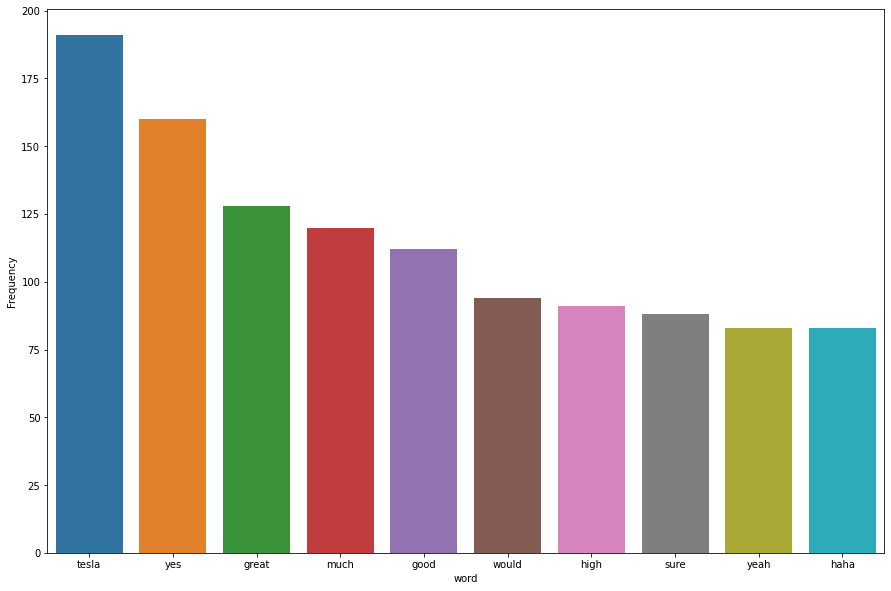

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.barplot(x='word',y='Frequency',data=kp_2020.head(10));

In [ ]:
import plotly.express as px    #importing to plot for histogram

In [ ]:
px.histogram(kp_2020, x ='Frequency', nbins =30)  #plotting histogram for 2020 tweets and taking bin size as 30

**Zipf's Law for 2020**

In [ ]:
kp_2020['rank'] = range(1,len(kp_2020)+1)      #addition of a rank column to the dataframe

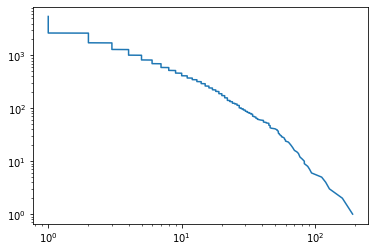

In [ ]:
plt.loglog(kp_2020['Frequency'], kp_2020['rank'] )   #zipf's law log-log plot for the year 2020

**Biogram for 2020**

In [ ]:

get_bigram2020 = [list(bigrams(tweet)) for tweet in data1[data1['year']==2020]['Tokens']]    #getting biograms for the year 2020

In [ ]:
flat2020 = list(itertools.chain(*get_bigram2020))    #flattening the list
counter2020 = collections.Counter(flat2020)           #declaring the counter

In [ ]:

bigram2020 = pd.DataFrame(counter2020.most_common(20),columns=['bigram', 'count'])   #creating the dataframe

In [ ]:
bigram2020    #printing the dataframe

,bigram,count
0,"(pretty, much)",35
1,"(coming, soon)",19
2,"(giga, berlin)",18
3,"(static, fire)",13
4,"(haha, true)",12
5,"(false, positive)",12
6,"(long, term)",12
7,"(good, point)",11
8,"(next, week)",10
9,"(years, ago)",10


In [ ]:

dictonary = bigram2020.set_index('bigram').T.to_dict('records')     #declaring a dictionary

In [ ]:

G = nx.Graph()


for k, v in dictonary[0].items():   #looping using for loop to make connections
    G.add_edge(k[0], k[1])

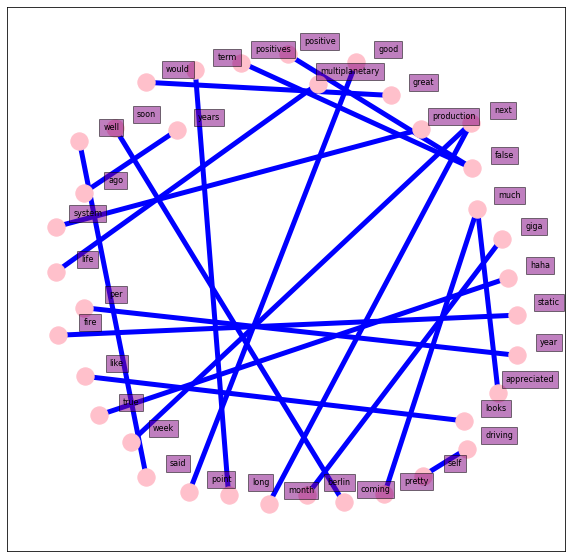

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

pos = nx.spring_layout(G, k=5)


nx.draw_networkx(G, pos,                        #plotting the networks
                 font_size=10,                   #specifying font size as 10
                 width=5,                        #specifying width as 5
                 edge_color='blue',              #specifying the edge color as blue
                 node_color='pink',              #specifying node color as pink
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='purple', alpha=0.50), #specifying the faceclor as purple
            horizontalalignment='center', fontsize=8)  #specifying the alignment as center
    
plt.show()


**Year 2021**

In [ ]:
kp_2021 = pd.DataFrame(f_2021.items(),columns =['word','Frequency']).sort_values(['Frequency'],ascending =False)    #Top 10 words for the year 2021

**Top 10 words of 2021**

In [ ]:
kp_2021.head(10)                   #printing of the top 10 words of 2021

,word,Frequency
48,tesla,213
65,great,102
143,good,98
111,much,93
156,would,89
96,haha,89
117,like,89
32,time,86
807,beta,77
927,high,74


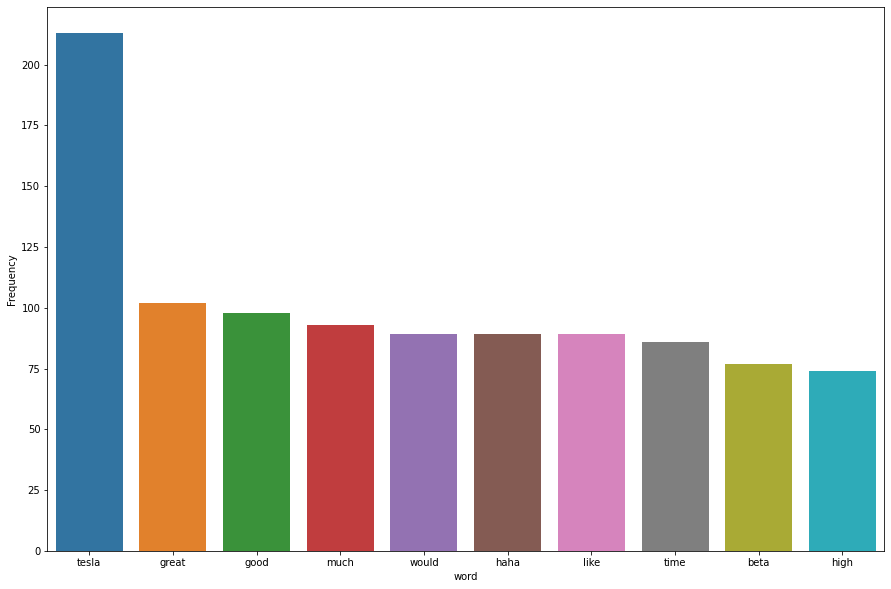

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.barplot(x='word',y='Frequency',data=kp_2021.head(10));

In [ ]:
import plotly.express as px   #importing to plot for histogram

In [ ]:
px.histogram(kp_2021, x ='Frequency', nbins =30)    #plotting of the histogram for the 2021 tweets with bin size as 30

**Zipf's Law for 2021**

In [ ]:
kp_2021['rank'] = range(1,len(kp_2021)+1)      #addition of a rank column to the dataframe

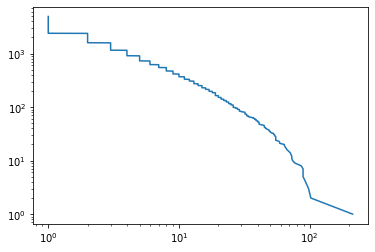

In [ ]:
plt.loglog(kp_2021['Frequency'], kp_2021['rank'] )    #zipf's law log-log plot for the year 2021

**Bigram for the year 2021**

In [ ]:

get_bigram2021 = [list(bigrams(tweet)) for tweet in data1[data1['year']==2021]['Tokens']]

In [ ]:

flat2021 = list(itertools.chain(*get_bigram2021))    #flattening the list

counter2021 = collections.Counter(flat2021)          #declaring the counter

In [ ]:

bigram2021 = pd.DataFrame(counter2021.most_common(20),
                             columns=['bigram', 'count'])    #initialising a dataframe

In [ ]:
bigram2021       #printing the dataframe

,bigram,count
0,"(fsd, beta)",21
1,"(long, term)",19
2,"(pure, vision)",16
3,"(life, multiplanetary)",16
4,"(self, driving)",16
5,"(next, week)",15
6,"(next, year)",14
7,"(super, heavy)",13
8,"(pretty, much)",13
9,"(supply, chain)",13


In [ ]:

dictonary = bigram2021.set_index('bigram').T.to_dict('records')    #declaring a dictionary

In [ ]:

G = nx.Graph()
for k, v in dictonary[0].items():   #looping through the network
    G.add_edge(k[0], k[1])

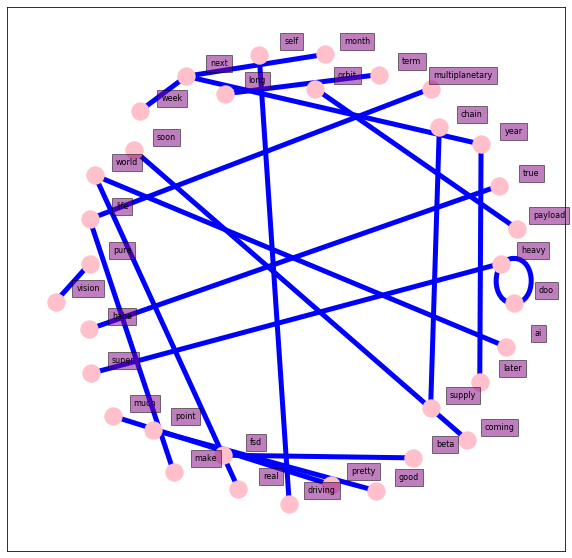

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

pos = nx.spring_layout(G, k=5)


nx.draw_networkx(G, pos,                    #plotting the networks
                 font_size=10,              #specifying the font size as 10
                 width=5,                   #specifying the width as 5
                 edge_color='blue',         #specifying the edge colour as blue
                 node_color='pink',         #specifying the node color as pink
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='purple', alpha=0.50),  #specifying the face colour as purple
            horizontalalignment='center', fontsize=8)    #specifying the alignment as center
    
plt.show()

**Year 2022**

In [ ]:

kp_2022 = pd.DataFrame(f_2022.items(),columns =['word','Frequency']).sort_values(['Frequency'],ascending =False)   #calculating top 10 words for 2022

**Top 10 words in 2022**

In [ ]:
kp_2022.head(10)       #printing the top 10 words in 2022

,word,Frequency
63,tesla,62
54,people,34
60,would,32
107,yes,32
245,one,30
323,good,28
7,starlink,28
158,car,26
686,true,22
134,high,22


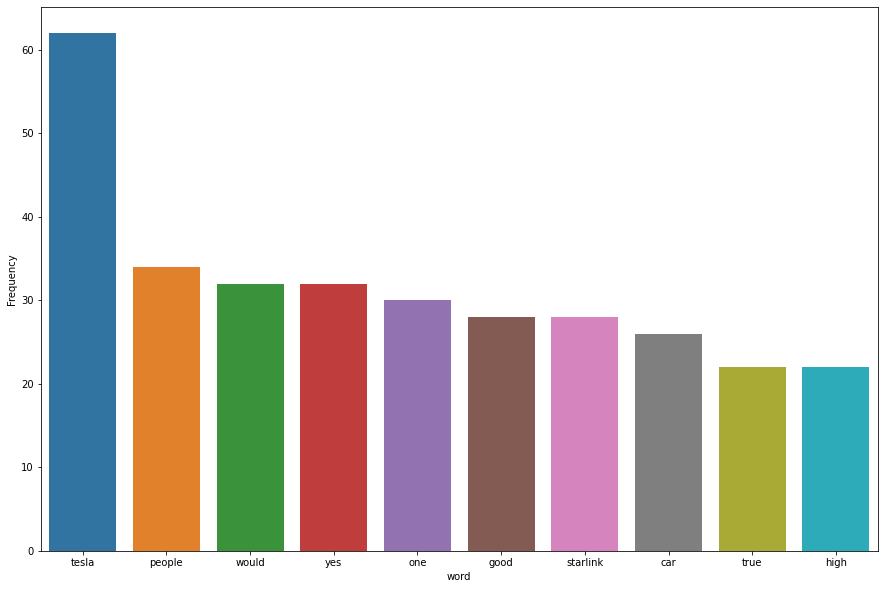

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.barplot(x='word',y='Frequency',data=kp_2022.head(10));

In [ ]:

px.histogram(kp_2022, x ='Frequency', nbins =30)      #Histogram for the year 2022 with the bin size as 30

**Zipf's Law for 2022**

In [ ]:
kp_2022['rank'] = range(1,len(kp_2022)+1)       #addition of a rank column to the dataframe

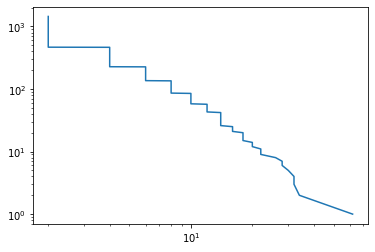

In [ ]:
plt.loglog(kp_2022['Frequency'], kp_2022['rank'] )     #zipf's law log-log plot for the year 2022

**Bigram for year 2022**

In [ ]:

get_bigram2022 = [list(bigrams(tweet)) for tweet in data1[data1['year']==2022]['Tokens']]    #getting the data for the year 2022

In [ ]:

flat2022 = list(itertools.chain(*get_bigram2022))   #flattening the list
counter2022 = collections.Counter(flat2022)         #declaring counter

In [ ]:

bigram2022 = pd.DataFrame(counter2022.most_common(20),
                             columns=['bigram', 'count'])   #initialising a data frame

In [ ]:
bigram2022

,bigram,count
0,"(birth, rate)",8
1,"(model, x)",8
2,"(sustainable, energy)",6
3,"(work, tesla)",6
4,"(self, driving)",6
5,"(neural, nets)",6
6,"(last, year)",6
7,"(life, multiplanetary)",6
8,"(starlink, terminals)",4
9,"(news, sources)",4


In [ ]:

dictonary = bigram2022.set_index('bigram').T.to_dict('records')  #declaring a dictionary

In [ ]:

G = nx.Graph()


for k, v in dictonary[0].items():   #looping using a for loop to link the network
    G.add_edge(k[0], k[1])

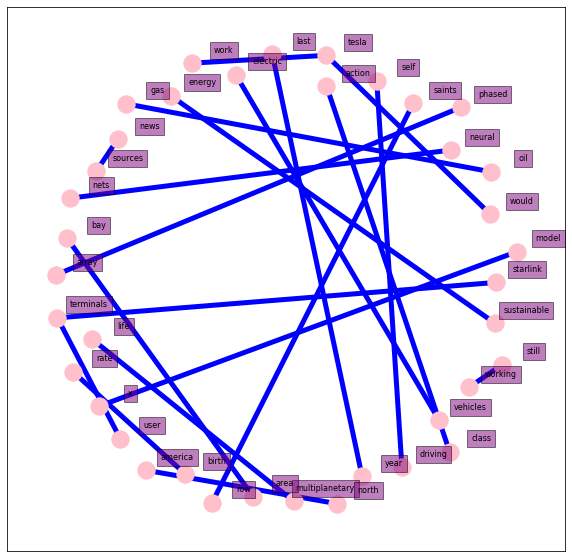

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

pos = nx.spring_layout(G, k=5)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,     #specifying font size as 10
                 width=5,           #specifying width as 5
                 edge_color='blue',   #specifying edge colour as blue
                 node_color='pink',    #specifying node colour as pink
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='purple', alpha=0.50),   #specifying face colour as pruple
            horizontalalignment='center', fontsize=8)     #specifying alignment as center
    
plt.show()


In [ ]:
!jupyter nbconvert --to html FDA_project3_Task2_New.ipynb

[NbConvertApp] WARNING | pattern 'FDA_project3_Task2_New.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--